# CPD using TIRE

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences
import warnings
import time, copy

import utils
import TIRE
import simulate
from importlib import reload 

# experiments 
import experiments.replication as x
import experiments


## Set parameters

In [2]:
# ipynb, mỗi lần đổi code, phải restart kernal để load lại toàn bộ. Import thì chỉ lấy từ cache, ko lấy được code mới. Lý do

In [3]:
workflow = x.Experiment()
workflow.set_hyperparameter_type('alpha')

## Generate data

In [4]:
timeseries, windows_TD, windows_FD = workflow.get_timeseries()

breakpoints = workflow.get_breakpoint(len(timeseries))

## Train the autoencoders

In [5]:
shared_features_TD, shared_features_FD = workflow.train_autoencoder(windows_TD, windows_FD)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 100)]     0           []                               
                                                                                                  
 dense (Dense)                  (None, 3, 1)         101         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 3, 0)         0           ['input_1[0][0]']                
                                                                                                  
 tf.concat (TFOpLambda)         (None, 3, 1)         0           ['dense[0][0]',                  
                                                                  'dense_1[0][0]']            

## Postprocessing and peak detection

In [6]:
# post process for TD, FD and both, then save to file 
workflow.dissimilarities_post_process(shared_features_TD, shared_features_FD)

c:\Users\Minh Nhat\Downloads\DCU\Practicum\TIRE-custom\experiments\../data/dissimilarities_replication_alpha/dissimilarities_TD.txt
c:\Users\Minh Nhat\Downloads\DCU\Practicum\TIRE-custom\experiments\../data/dissimilarities_replication_alpha/dissimilarities_FD.txt
c:\Users\Minh Nhat\Downloads\DCU\Practicum\TIRE-custom\experiments\../data/dissimilarities_replication_alpha/dissimilarities_both.txt


mode: TD
[0.5271220259999357]


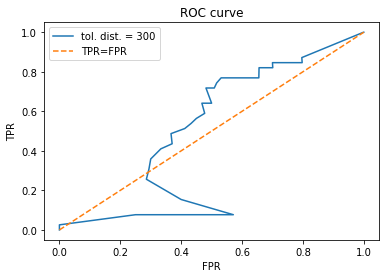

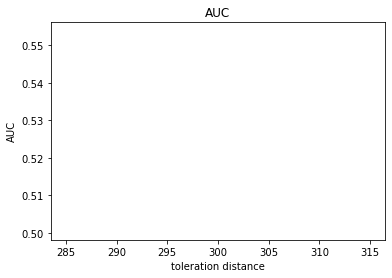

mode: FD
[0.633204717795401]


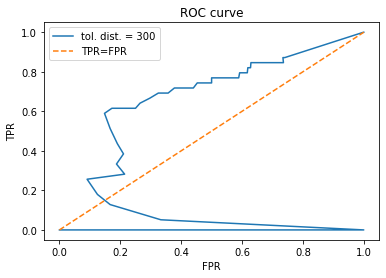

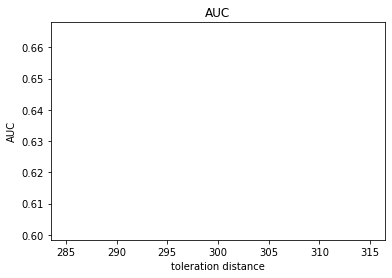

mode: both
[0.6235118169211178]


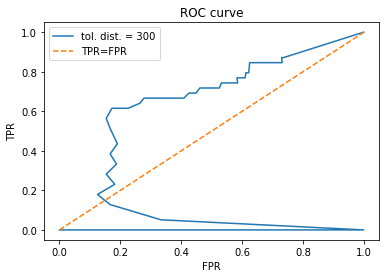

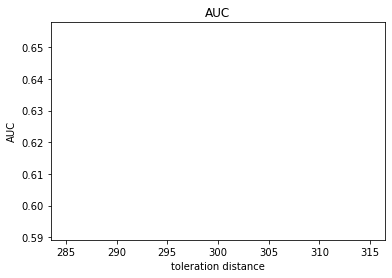

In [7]:
workflow.get_auc(breakpoints)